In [4]:
import requests
import pandas as pd
import lxml.html as lh
from bs4 import BeautifulSoup as soup
import numpy as np 
import re
from matplotlib.gridspec import GridSpec
from matplotlib.widgets import RadioButtons

%matplotlib inline
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
url_tokyo = 'https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47662&view=1'
url_kyoto = 'https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47759&view=1'
url_asahikawa = 'https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47407&view=1'

def scrape_table(url):
    page = requests.get(url)
    content = soup(page.text, "html.parser")
    doc = lh.fromstring(page.content)
    table = doc.xpath("//tr")
    table = table[2:]
    data = [[0 for x in range(len(table[0]))] for y in range(len(table))]

    for row, line in enumerate(table):
        for col, val in enumerate(line):
            text = val.text_content()
            if re.findall("\s[])*]", text) != []:
                text = text.replace(re.findall("\s[])*]", text)[0], "")
            if text in ["-", " ", "", "\u3000", "×"]:
                text = np.nan
            data[row][col] = text

    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df.set_index("Year", inplace=True)
    df.index = df.index.astype(np.int64)
    for col in df.columns:
        df[col] = df[col].astype(np.float64)
    return df

tokyo = scrape_table(url_tokyo)
kyoto = scrape_table(url_kyoto)
asahikawa = scrape_table(url_asahikawa)

tokyo = tokyo.loc[kyoto.index]
tokyo2 = tokyo.loc[asahikawa.index]

tokyo = tokyo.iloc[1:(tokyo.shape[0]-1)] #remove NaN rows
tokyo2 = tokyo2.iloc[1:(tokyo2.shape[0]-1)]
kyoto = kyoto.iloc[1:(tokyo.shape[0]-1)] #remove NaN rows


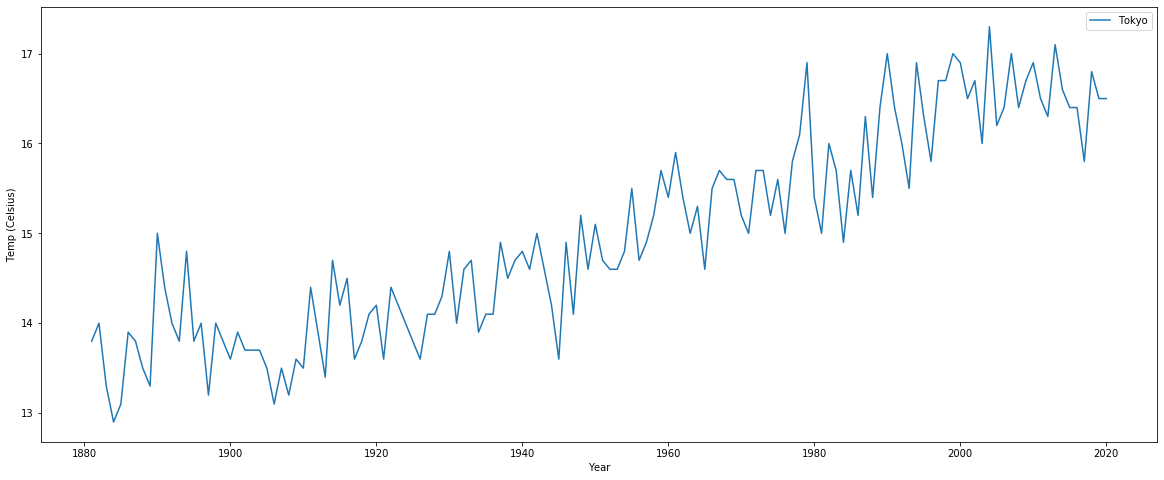

In [147]:
%matplotlib inline
from matplotlib import pyplot as plt 
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(tokyo.index, tokyo["Annual"], label="Tokyo");
# ax.plot(kyoto.index, kyoto["Annual"], label= "Kyoto")
d = [[0 for x in range(tokyo.shape[0])] for y in range(2)]
ax.set_xlabel("Year")
ax.set_ylabel("Temp (Celsius)")
plt.legend()

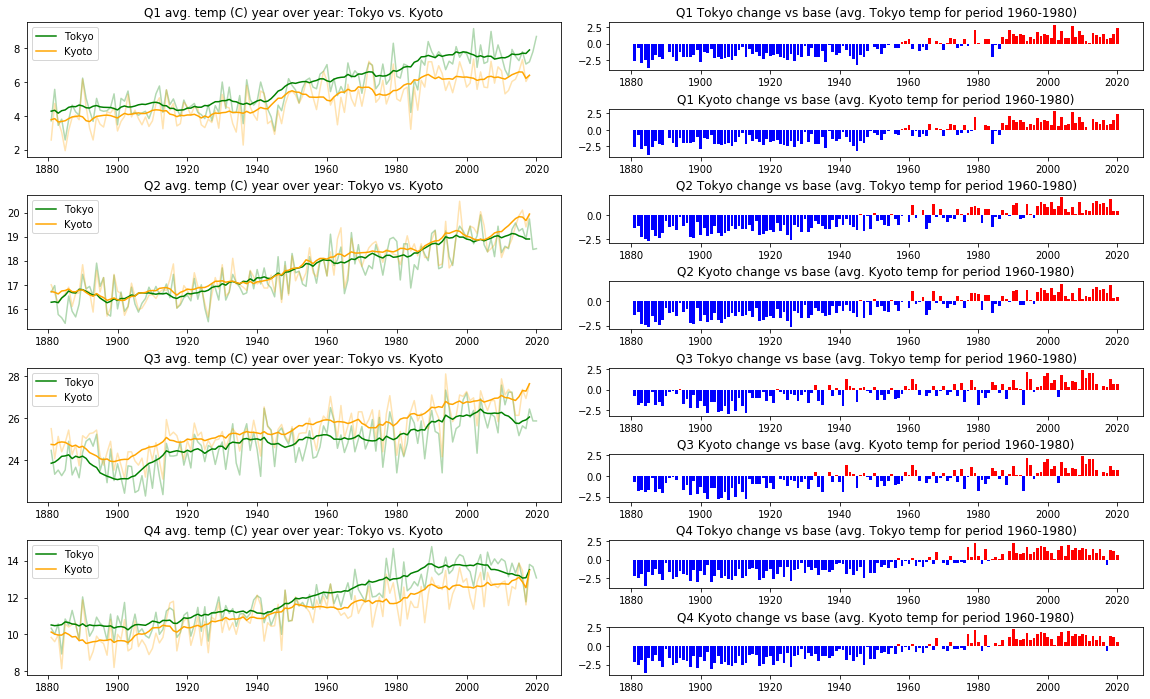

In [9]:
q1 = ["Jan", "Feb", "Mar"]
q2 = ["Apr", "May", "Jun"]
q3 = ["Jul", "Aug", "Sep"]
q4 = ["Oct", "Nov", "Dec"]
qs = [q1,q2,q3,q4]

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(20,12))
fig = plt.figure(figsize=(20,12))
grid = GridSpec(8,4, hspace=0.8)

ax_q4 = plt.subplot(grid[6:8, :2])
ax_q1 = plt.subplot(grid[:2,:2], sharex=ax_q4)
ax_q2 = plt.subplot(grid[2:4, :2], sharex=ax_q4)
ax_q3 = plt.subplot(grid[4:6, :2], sharex=ax_q4)

ax_roll8 = plt.subplot(grid[7, 2:])
ax_roll1 = plt.subplot(grid[0, 2:], sharex=ax_roll8)
ax_roll2 = plt.subplot(grid[1, 2:], sharex=ax_roll8)
ax_roll3 = plt.subplot(grid[2, 2:], sharex=ax_roll8)
ax_roll4 = plt.subplot(grid[3, 2:], sharex=ax_roll8)
ax_roll5 = plt.subplot(grid[4, 2:], sharex=ax_roll8)
ax_roll6 = plt.subplot(grid[5, 2:], sharex=ax_roll8)
ax_roll7 = plt.subplot(grid[6, 2:], sharex=ax_roll8)

ax_rolls=((ax_roll1, ax_roll2), (ax_roll3, ax_roll4), (ax_roll5, ax_roll6), (ax_roll7, ax_roll8))

def draw_quarterly(ax1,ax2,ax3,ax4, qs, city1_df, city2_df, city_names):
    def maxmin(city_df):
        temp_maxmin = [[0 for i in range(round(city_df.shape[0]/10))] for i in range(4)]
        for ind, year in enumerate(range(city_df.index[0], city_df.index[-1]+1, 10)):
            decade = [x for x in range(year, year+10)]
            temp_maxmin[0][ind] = city_df.loc[decade].argmax()
            temp_maxmin[1][ind] = city_df.loc[decade].max()
            temp_maxmin[2][ind] = city_df.loc[decade].argmin()
            temp_maxmin[3][ind] = city_df.loc[decade].min()
        return temp_maxmin
    
    def rolling_agg(city_df, step=10, agg_func = np.mean):
        x = []
        y = []
        for i in kyoto.index:
            x.append(i)
            y.append(agg_func(city_df.loc[i:i+step]))
        return x,y


    for ind, (ax, q) in enumerate(zip((ax1, ax2, ax3, ax4), qs)):
        city1_q = city1_df[q].apply(np.mean, axis=1)
        city2_q = city2_df[q].apply(np.mean, axis=1)
        city1_color = "green"
        city2_color = "orange"

        ax.plot(city1_df.index, city1_q, alpha=0.3, color=city1_color)
        ax.plot(city2_df.index, city2_q, alpha=0.3, color=city2_color)

        # ax.scatter(maxmin(city1_q)[0], maxmin(city1_q)[1], color="r")
        # ax.scatter(maxmin(city2_q)[0], maxmin(city2_q)[1], color="r")
        # ax.scatter(maxmin(city1_q)[2], maxmin(city1_q)[3], color="b")
        # ax.scatter(maxmin(city2_q)[2], maxmin(city2_q)[3], color="b")

        city1_roll = rolling_agg(city1_q)
        city2_roll = rolling_agg(city2_q)

        ax.plot(city1_roll[0], city1_roll[1], label=city_names[0], color=city1_color)
        ax.plot(city2_roll[0], city2_roll[1], label=city_names[1], color=city2_color)

        ax.set_title(f"Q{ind+1} avg. temp (C) year over year: {city_names[0]} vs. {city_names[1]}")
        ax.legend()
        # plt.draw()

# draw_quarterly(ax1,ax2,ax3,ax4,qs, tokyo, kyoto, ["Tokyo", "Kyoto"])
def draw_change_bar(city1_df, city2_df, qs, axes, city_names, base_start=1960, base_end=1980):
    
    def neg_pos(df, start, end):
        x=[[],[]]
        y=[[],[]]

        base_range = [x for x in range(start,end)]
        base = df.loc[base_range].mean()

        for i in range(tokyo.shape[0]):
            diff = df.iloc[i]-base
            if diff>=0:
                x[0].append(tokyo.index[i])
                y[0].append(diff)
            else:
                x[1].append(tokyo.index[i])
                y[1].append(diff)
        return x, y
    
    for ind, (ax_pair, q) in enumerate(zip(axes,qs)):
        city1_q = city1_df[q].apply(np.mean, axis=1)
        city2_q = city2_df[q].apply(np.mean, axis=1)

        city1_x, city1_y = neg_pos(city1_q, base_start, base_end)
        city2_x, city2_y = neg_pos(city1_q, base_start, base_end)

        ax_pair[0].bar(city1_x[0], city1_y[0], color="red")
        ax_pair[0].bar(city1_x[1], city1_y[1], color="blue")
        ax_pair[0].set_title(f'Q{ind+1} {city_names[0]} change vs base (avg. {city_names[0]} temp for period {base_start}-{base_end})')

        ax_pair[1].bar(city2_x[0], city2_y[0], color="red")
        ax_pair[1].bar(city2_x[1], city2_y[1], color="blue")
        ax_pair[1].set_title(f'Q{ind+1} {city_names[1]} change vs base (avg. {city_names[1]} temp for period {base_start}-{base_end})')
        # plt.draw()

draw_quarterly(ax_q1, ax_q2, ax_q3, ax_q4,qs, tokyo, kyoto, ["Tokyo", "Kyoto"])
draw_change_bar(tokyo, kyoto, qs, ax_rolls, ["Tokyo", "Kyoto"])
plt.show()



## NEXT STEP: Identify max temp by decade

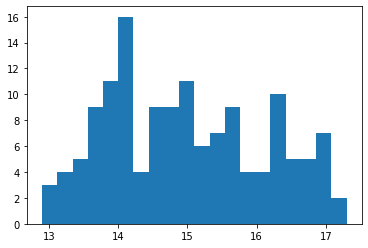

In [98]:
plt.figure()
plt.hist(tokyo["Annual"], bins=20);

In [126]:
for ind, i in enumerate(range(kyoto.index[0], kyoto.index[-1]+1, 10)):
    decade = [x for x in range(i, i+10)]
    print(kyoto.loc[decade]["Annual"].argmin(), kyoto.loc[decade]["Annual"].min())
    # print(ind, i)

1884 13.0
1893 13.2
1906 13.2
1913 13.2
1926 13.4
1934 13.8
1945 13.7
1957 14.5
1965 14.3
1980 14.8
1981 14.6
1993 15.2
2003 15.8
2012 15.8


In [141]:
def maxmin(city_df):
    temp_maxmin = [[0 for i in range(int(city_df.shape[0]/10))] for i in range(4)]
    i=0
    for ind, year in enumerate(range(city_df.index[0], city_df.index[-1]+1, 10)):
        print(ind,year)
        # decade = [x for x in range(year, year+10)]
        # try:
        #     temp_maxmin[0][ind] = city_df.loc[decade].argmax()
        #     i+=1
        # except:
        #     print(i, ind, year)
    #     temp_maxmin[1][ind] = city_df.loc[decade].max()
    #     temp_maxmin[2][ind] = city_df.loc[decade].argmin()
    #     temp_maxmin[3][ind] = city_df.loc[decade].min()
    # return temp_maxmin

int(kyoto.shape[0]/10)

13

In [149]:
d = [[0 for x in range(tokyo.shape[0])] for y in range(2)]
for ind, x in enumerate(tokyo["Annual"].iloc[:(tokyo.shape[0]-10)]):
    tokyo

AttributeError: 'list' object has no attribute 'shape'

In [199]:
x = []
y = []
for i in kyoto.index:
    x.append(i)
    y.append(np.mean(kyoto["Annual"].loc[i:i+10]))
plt.figure()
plt.plot(x,y)
plt.plot(tokyo.index, tokyo["Annual"])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([min(y), max(y)])
ax.set_yticklabels(["{:.1f}".format(min(y)), "{:.1f}".format(max(y))])
hori = [min(y) for i in range(np.argmin(y))]
hori2 = [max(y) for i in range(np.argmax(y))]
ax.plot(x[:np.argmin(y)], hori, color="grey", alpha=0.5)
ax.plot(x[:np.argmax(y)], hori2, color="grey", alpha=0.5)
vert = [x[np.argmin(y)] for i in range(round(min(y)))]
# ax.fill_between(x, hori, hori2)
ax.set_xlim(left=min(x))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (13,) and (1,)

<BarContainer object of 66 artists>

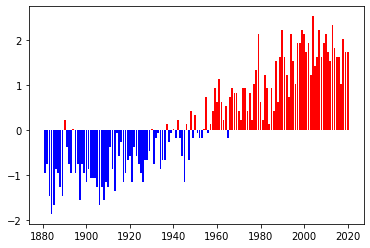

In [200]:
x=[[],[]]
y=[[],[]]

base_range = [x for x in range(1940,1960)]
base = tokyo["Annual"].loc[base_range].mean()

for i in range(tokyo.shape[0]):
    diff = tokyo["Annual"].iloc[i]-base
    if diff>=0:
        x[0].append(tokyo.index[i])
        y[0].append(diff)
    else:
        x[1].append(tokyo.index[i])
        y[1].append(diff)

plt.figure()
plt.bar(x[0], y[0], color="red")
plt.bar(x[1], y[1], color="blue")

0

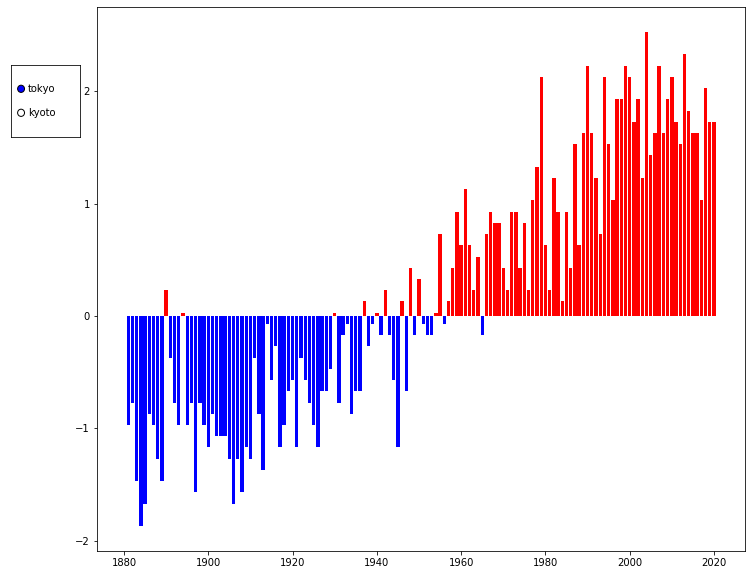

In [24]:
def output_change(df):
    x=[[],[]]
    y=[[],[]]

    base_range = [x for x in range(1940,1960)]
    base = df["Annual"].loc[base_range].mean()

    for i in range(df.shape[0]):
        diff = df["Annual"].iloc[i]-base
        if diff>=0:
            x[0].append(df.index[i])
            y[0].append(diff)
        else:
            x[1].append(df.index[i])
            y[1].append(diff)
    return x, y

tokyo_x, tokyo_y = output_change(tokyo)
kyoto_x, kyoto_y = output_change(tokyo)

changes = {"tokyo":[tokyo_x, tokyo_y], "kyoto":[kyoto_x, kyoto_y]}

fig = plt.figure(figsize=(12,10))

def draw(x,y,alpha):
    plt.bar(x[0], y[0], color="red", alpha=alpha)
    plt.bar(x[1], y[1], color="blue", alpha=alpha)

draw(tokyo_x, tokyo_y, alpha=1)
draw(kyoto_x, kyoto_y, alpha=0.3)
plt.subplots_adjust(left=0.15)

radioax = plt.axes([0.05,0.7,0.08,0.1])
radio = RadioButtons(radioax, ["tokyo", "kyoto"])

def highlight(label):
    x1, y1 = changes[label]
    x2, y2 = changes[[lab for lab in list(changes.keys()) if lab != label][0]]
    draw(x1, y1, alpha=1)
    draw(x2, y2, alpha=0.3)
    plt.draw()
radio.on_clicked(highlight)

In [205]:
from matplotlib.gridspec import GridSpec

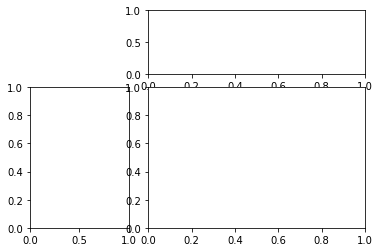

In [216]:
grid = GridSpec(3,3)
fig = plt.figure()
ax1 = plt.subplot(grid[0,1:])
ax2 = plt.subplot(grid[1:, 0])
ax3 = plt.subplot(grid[1:,1:])
plt.show()

0
1
2
3


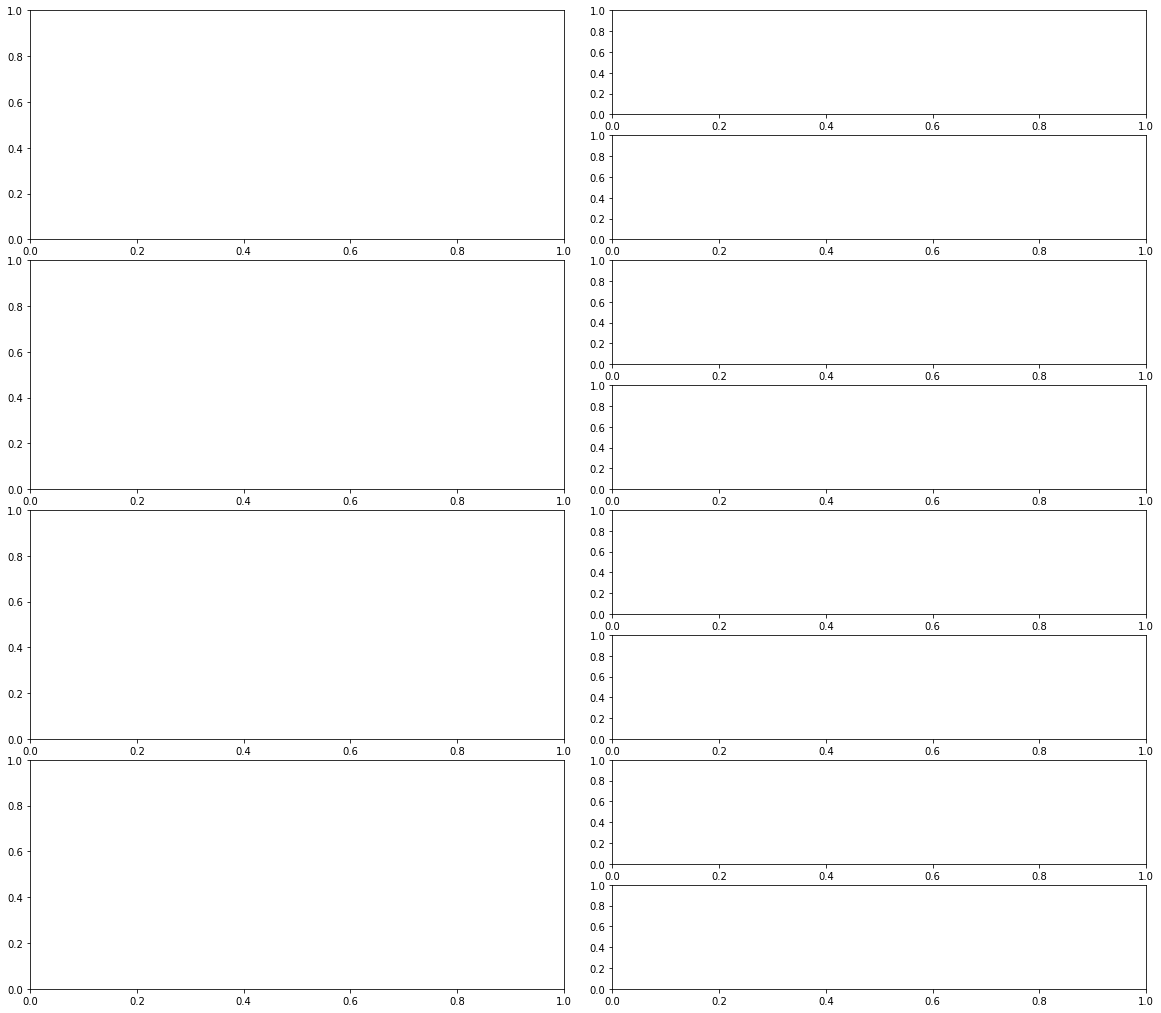

In [232]:
fig = plt.figure(figsize=(20,18))
grid = GridSpec(8,4)

ax_q4 = plt.subplot(grid[6:8, :2])
ax_q1 = plt.subplot(grid[:2,:2], sharex=ax_q4)
ax_q2 = plt.subplot(grid[2:4, :2], sharex=ax_q4)
ax_q3 = plt.subplot(grid[4:6, :2], sharex=ax_q4)

ax_roll8 = plt.subplot(grid[7, 2:])
ax_roll1 = plt.subplot(grid[0, 2:], sharex=ax_roll8)
ax_roll2 = plt.subplot(grid[1, 2:], sharex=ax_roll8)
ax_roll3 = plt.subplot(grid[2, 2:], sharex=ax_roll8)
ax_roll4 = plt.subplot(grid[3, 2:], sharex=ax_roll8)
ax_roll5 = plt.subplot(grid[4, 2:], sharex=ax_roll8)
ax_roll6 = plt.subplot(grid[5, 2:], sharex=ax_roll8)
ax_roll7 = plt.subplot(grid[6, 2:], sharex=ax_roll8)

ax_rolls=((ax_roll1, ax_roll2), (ax_roll3, ax_roll4), (ax_roll5, ax_roll6), (ax_roll7, ax_roll8))

q=[1,2,3,4]

for ax, q in enumerate(zip(ax_rolls,q)):
    print(ax)

In [23]:
a = {"a":[1,2], "b":[3,4]}
# t1, t2 = a[~"b"]
[x for x in list(a.keys()) if x !="b"]

['a']